In [5]:
import random
import torch

from peft import LoraConfig
from transformers import CLIPVisionModelWithProjection
from diffusers import UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky
from diffusers import PriorTransformer
from diffusers.utils import make_image_grid

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"

In [7]:
movq = VQModel.from_pretrained(
            decoder_model_path, subfolder="movq", torch_dtype=torch.float16
        ).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    prior_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()

prior = PriorTransformer.from_pretrained(
    prior_model_path, subfolder="prior", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()

controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
    decoder_model_path, subfolder="controlnet/canny", torch_dtype=torch.float16
).eval()

The config attributes {'center_input_sample': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [8]:
lora_config = LoraConfig(
        r=4,
        lora_alpha=4,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
lora_config.init_lora_weights = False

prior.add_adapter(lora_config)

In [9]:
prior.load_state_dict(torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/Kandinsky/lora/prior/FavorfitStyle.pth"))

<All keys matched successfully>

In [10]:
prior.enable_adapters()

In [11]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        prior_model_path,
        image_encoder=image_encoder,
        prior=prior,
        torch_dtype=torch.float16,
    )
pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
    decoder_model_path,
    movq=movq,
    controlnet=controlnet_kandinsky,
    # unet=unet,
    torch_dtype=torch.float16,
)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]
The config attributes {'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} were passed to KandinskyV22ControlnetPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} are not expected by KandinskyV22ControlnetPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]


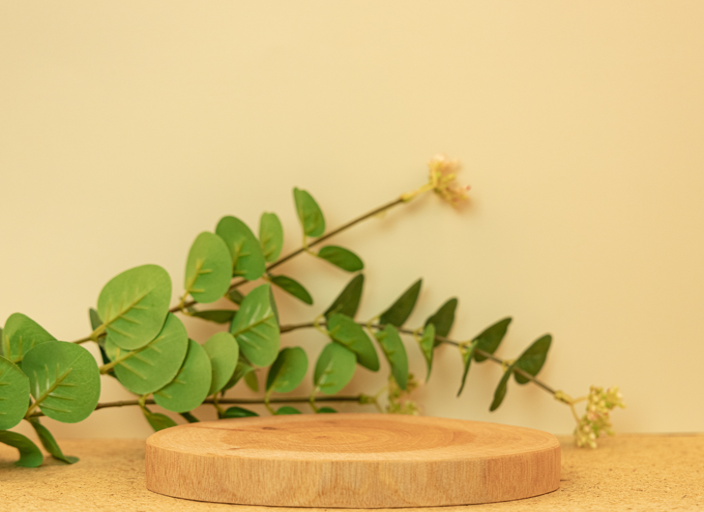

In [12]:
from utils import *
from PIL import Image

init_image = Image.open("/media/mlfavorfit/sdb/favorfit_templates/templates/180/1000.jpg").convert("RGB")
init_image = resize_store_ratio(init_image, 512)
init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
canny_image = make_canny_condition(init_image)
width, height = init_image.size
init_image

In [57]:
concept = ["", "epic render", "3d render, epic render"]
prompt_color_blocks = ["magenta theme", "pink theme", "orange theme", "yellow theme", "brown theme", "turquoise theme", "green theme", "blue theme", "purple theme", "black theme", "white theme"]

positive_prompt = "product photo background, clean, masterpiece, award winning, high-resolution realistic image, pastel color, 4k"
negative_prompt = "human, including any identifying information such as logos, brand names, or product numbers. referencing copyrighted images or other product templates. generating low-resolution, blurry, or unclear images. having the product be disproportionate or distorted. Avoid generating images with the product damaged or altered."

In [58]:
from Favorfit_image_to_text import clip_image_to_text

clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")
caption = clip_image_to_text.inference(init_image, clip_model, mode="simple" ,remove_color=True)

In [168]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

num_images_per_prompt = 4
generator = [torch.Generator(device="cuda").manual_seed(random.randint(0,100000)) for _ in range(num_images_per_prompt)]

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        # prompt=f"{{FavorfitStyle}}, blue theme",
        prompt=f"{{FavorfitStyle}}, product photo backgorund, white theme",
        # prompt=f"product photo background",
        negative_prompt=negative_prompt, 
        generator=generator
    )

    generated_image = pipeline(
        image=init_image,
        control_image=canny_image,
        **prior_output,
        height=height,
        width=width,
        num_inference_steps=40,
        strength=1.0,
        guidance_scale=2.0,
        controlnet_scale=0.6,
        generator=generator,
        num_images_per_prompt=num_images_per_prompt
    ).images

100%|██████████| 40/40 [00:14<00:00,  2.76it/s]


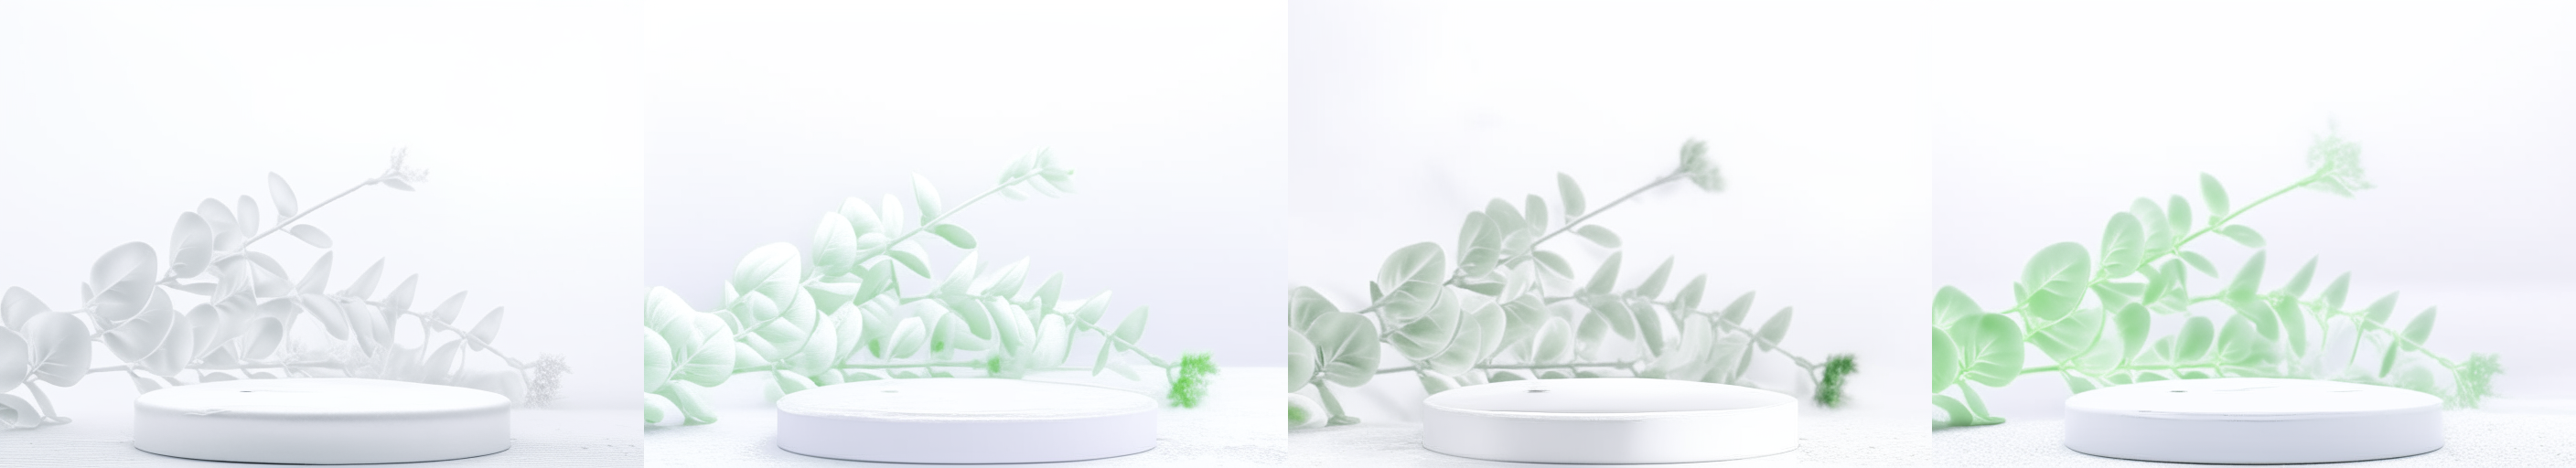

In [169]:
make_image_grid(generated_image,1,4)

In [27]:
pre_prior_output = prior_output

In [29]:
ff_prior_output = prior_output

In [48]:
torch.max(ff_prior_output["negative_image_embeds"])

tensor(6.3008, device='cuda:0', dtype=torch.float16)

In [49]:
torch.max(pre_prior_output["negative_image_embeds"])

tensor(4.5820, device='cuda:0', dtype=torch.float16)

In [2]:
import random
import torch

from peft import LoraConfig
from transformers import CLIPVisionModelWithProjection
from diffusers import UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky
from diffusers import PriorTransformer
from diffusers.utils import logging

from utils import *

In [3]:
from Favorfit_image_to_text import clip_image_to_text

clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

In [4]:
try:
    del prior_pipeline
    del pipeline
    del controlnet_kandinsky
    torch.cuda.empty_cache()
except Exception as e:
    pass

logging.set_verbosity_error()

In [5]:
def prepare_models():
    prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"
    decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"

    movq = VQModel.from_pretrained(
        decoder_model_path, subfolder="movq", torch_dtype=torch.float16
    ).eval()
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        prior_model_path, subfolder="image_encoder", torch_dtype=torch.float16
    ).eval()
    prior = PriorTransformer.from_pretrained(
        prior_model_path, subfolder="prior", torch_dtype=torch.float16
    ).eval()
    unet = UNet2DConditionModel.from_pretrained(
        decoder_model_path, subfolder="unet", torch_dtype=torch.float16
    ).eval()
    controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
        decoder_model_path, subfolder="controlnet/canny", torch_dtype=torch.float16
    ).eval()

    lora_config = LoraConfig(
        r=4,
        lora_alpha=4,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        )
    lora_config.init_lora_weights = False

    unet.add_adapter(lora_config)
    prior.add_adapter(lora_config)

    prior.load_state_dict(torch.load("./kandi_2_2-model-finetuned-lora/prior-2000/pytorch_model.bin"))
    unet.load_state_dict(torch.load("kandi_2_2-model-finetuned-lora/decoder_lora/pytorch_model.bin"))

    prior.enable_adapters()
    unet.enable_adapters()

    prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        prior_model_path,
        image_encoder=image_encoder,
        prior=prior,
        torch_dtype=torch.float16,
    )
    prior_pipeline.set_progress_bar_config(disable=True)
    main_pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
        decoder_model_path,
        movq=movq,
        controlnet=controlnet_kandinsky,
        torch_dtype=torch.float16,
    )
    main_pipeline.set_progress_bar_config(disable=True)

    return {"prior_pipeline":prior_pipeline,
            "main_pipeline":main_pipeline}

models = prepare_models()

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


In [22]:
def template_augment(image_path, prompt, negative_prompt, models, num_images_per_prompt):

    init_image = Image.open(image_path).convert("RGB")
    init_image = resize_store_ratio(init_image, 512)
    init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
    canny_image = make_canny_condition(init_image)
    width, height = init_image.size


    prior_pipeline = models["prior_pipeline"].to("cuda")
    pipeline = models["main_pipeline"].to("cuda")

    generator = [torch.Generator(device="cuda").manual_seed(random.randint(0,100000)) for _ in range(num_images_per_prompt)]

    with torch.autocast("cuda", torch.float16):
        prior_output = prior_pipeline(
            prompt=prompt,
            negative_prompt=negative_prompt, 
            generator=generator,
        )

        generated_images = pipeline(
            image=init_image,
            control_image=canny_image,
            **prior_output,
            height=height,
            width=width,
            num_inference_steps=50,
            strength=1.0,
            guidance_scale=3.0,
            controlnet_scale=0.9,
            generator=generator,
            num_images_per_prompt=num_images_per_prompt
        ).images
    
    return generated_images

In [23]:
import re
def remove_stopwords(text):
    # 불용어 리스트를 "|"를 이용하여 정규표현식에 맞게 변환합니다.
    stopwords_pattern = r'[,\'\"\?\!]'
    # 정규표현식을 사용하여 불용어를 제거합니다.
    text_without_stopwords = re.sub(stopwords_pattern, '', text).replace(" ", "_")
    return text_without_stopwords

In [28]:
prompt_concept_blocks = ["3d render, epic render"]
prompt_color_blocks = ["", "red theme", "pink theme", "orange theme", "yellow theme", "brown theme", "turquoise theme", "green theme", "blue theme", "purple theme", "black theme", "white theme"]

positive_prompt = "clean, masterpiece, bestquality, ultra-detailed, studio photography, realistic, Photography, RAW photo, volumetric lighting, natural materials, raytraced 3d set design, raytracing shadows, image on the store website, natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
negative_prompt = "watermark, text, (depth of field:1.4),(bokeh:1.31),(blurry:1.4),(worst quality:1.4),(low quality:1.4),(monochrome:1.1),Sketch,ng_deepnegative_v1_75t,(nsfw:1.21),tattoo,(beard:1.3),(EasyNegative:1.3),badhandv4,(Teeth:1.3),(worst quality:2),(low quality:2),(normal quality:2),lowers,normal quality,facing away,looking away,text,error,extra digit,fewer digits,cropped,jpeg artifacts,signature,watermark,username,blurry,skin spots,acnes,skin blemishes,bad anatomy,fat,bad feet,cropped,poorly drawn hands,poorly drawn face,mutation,deformed,tilted head.bad anatomy.bad hands,extra fingers,fewer digits.,extra limbs.extra arms,extra legs,malformed limbs.fused fingers.,too many fingers,long neck,cross-eyed,mutated hands,bad body,bad proportions,gross proportions,text,error,missing fingers,missing arms,missing legs,extra digit,extra arms,extra leg,extra foot,missing fingers"

prompt_prefixs = [f"{concept}, {color}" for concept in prompt_concept_blocks for color in prompt_color_blocks]

In [29]:
import os
from glob import glob
from tqdm import tqdm

ff_90 = sorted(glob("/media/mlfavorfit/sdb/favorfit_templates/templates/90/*"))
ff_180 = sorted(glob("/media/mlfavorfit/sdb/favorfit_templates/templates/180/*"))
fp_premium = sorted(glob("/media/mlfavorfit/sdb/favorfit_templates/templates_freepik/premium/*"))

In [30]:
save_dir = "/media/mlfavorfit/sdb/favorfit_templates/template_kandinsky/ff_180"

target_fns = ff_180
num_image_per_prompt = 4

progress_bar = tqdm(range(0, len(target_fns) * len(prompt_prefixs)), desc="Running augmentation...")
for fn in target_fns:
    dir_name = os.path.basename(fn).split(".")[0]
    os.makedirs(f"{save_dir}/{dir_name}", exist_ok=True)

    caption = clip_image_to_text.inference(Image.open(fn).convert("RGB"), clip_model, mode="simple" ,remove_color=True)

    for prompt_prefix in prompt_prefixs:
        result_images = template_augment(
            image_path=fn, 
            prompt=f"{{FavorfitStyle}}, {prompt_prefix}, {positive_prompt}",
            negative_prompt=negative_prompt,
            models=models,
            num_images_per_prompt=num_image_per_prompt)

        for idx, image in enumerate(result_images):
            image.save(os.path.join(f"{save_dir}/{dir_name}", f"{remove_stopwords(prompt_prefix)}_{idx}.jpg"))
        
        progress_bar.update(1)

Running augmentation...:   0%|          | 3/984 [00:34<3:05:43, 11.36s/it]

KeyboardInterrupt: 